# Utilize the `pytket` compilation passes to decrease the number of two-qubit gates

1. Generate a random circuit using qiskit `random_circuit`.
2. Use Qiskit's `IBMProvider` to fetch and set up the IBMQ Jakarta backend with the `QiskitRuntimeService` account.
3. Transpile the circuit using Qiskit's `transpile` function at the highest optimization level, which is level 3.
4. Convert the `qiskit` circuit to a `pytket` circuit using `qiskit_to_tk`.
5. Use TKET's `IBMQBackend` to fetch and set up the IBMQ Jakarta backend.
6. Compile the circuit using TKET's default compilation pass `get_compiled_circuit`.
7. Convert the `pytket` circuit back to a `qiskit` circuit using `tk_to_qiskit`.

Requirments:
- `pytket`
- `matplotlib`
- `pytket-qiskit`


In [8]:
!pip install pytket --q

In [9]:
!pip install pytket-quantinuum --quiet

In [11]:
!pip install pytket-qiskit --q

In [21]:
!pip install pylatexenc --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [12]:
import warnings

warnings.filterwarnings('ignore')

In [1]:
from qiskit_ibm_runtime.session import QiskitRuntimeService
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import qiskit_runtime_service

IBMProvider.save_account(instance=" ", token =" ",overwrite=True)

#saving my QiskitRuntimeService account for future
QiskitRuntimeService.save_account(
    channel = 'ibm_quantum',
    instance = ' ',
    token = ' ',
    overwrite = True
)

/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:412: UserWarning: Default hub/group/project ibmq/open/main not found for the account and is ignored.
  warnings.warn(


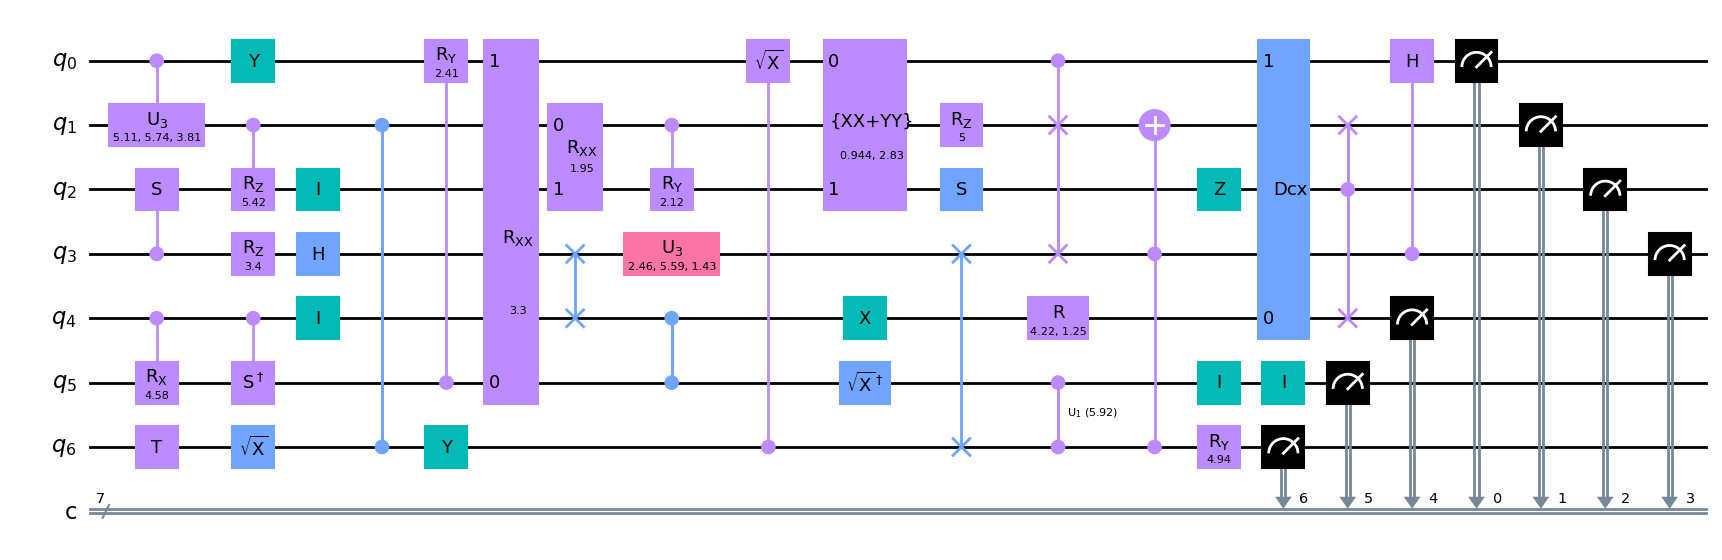

In [2]:
# setup IBMQ Jakarta backend
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.get_backend("ibmq_jakarta")

# import function to create random quantum circuit
from qiskit.circuit.random import random_circuit

# create a random circuit
qc = random_circuit(num_qubits=7, depth=9, max_operands=3, measure=True, seed=0)
qc.draw(output='mpl')  #The 'pylatexenc' library is required to use 'MatplotlibDrawer'


In [3]:
# import the transpile function that performs the transpilation
from qiskit import transpile
transpiled_qc = transpile(qc, backend=backend, optimization_level=3)

transpiled_qc.count_ops()


OrderedDict([('rz', 107),
             ('cx', 104),
             ('sx', 51),
             ('x', 8),
             ('measure', 7),
             ('barrier', 1)])

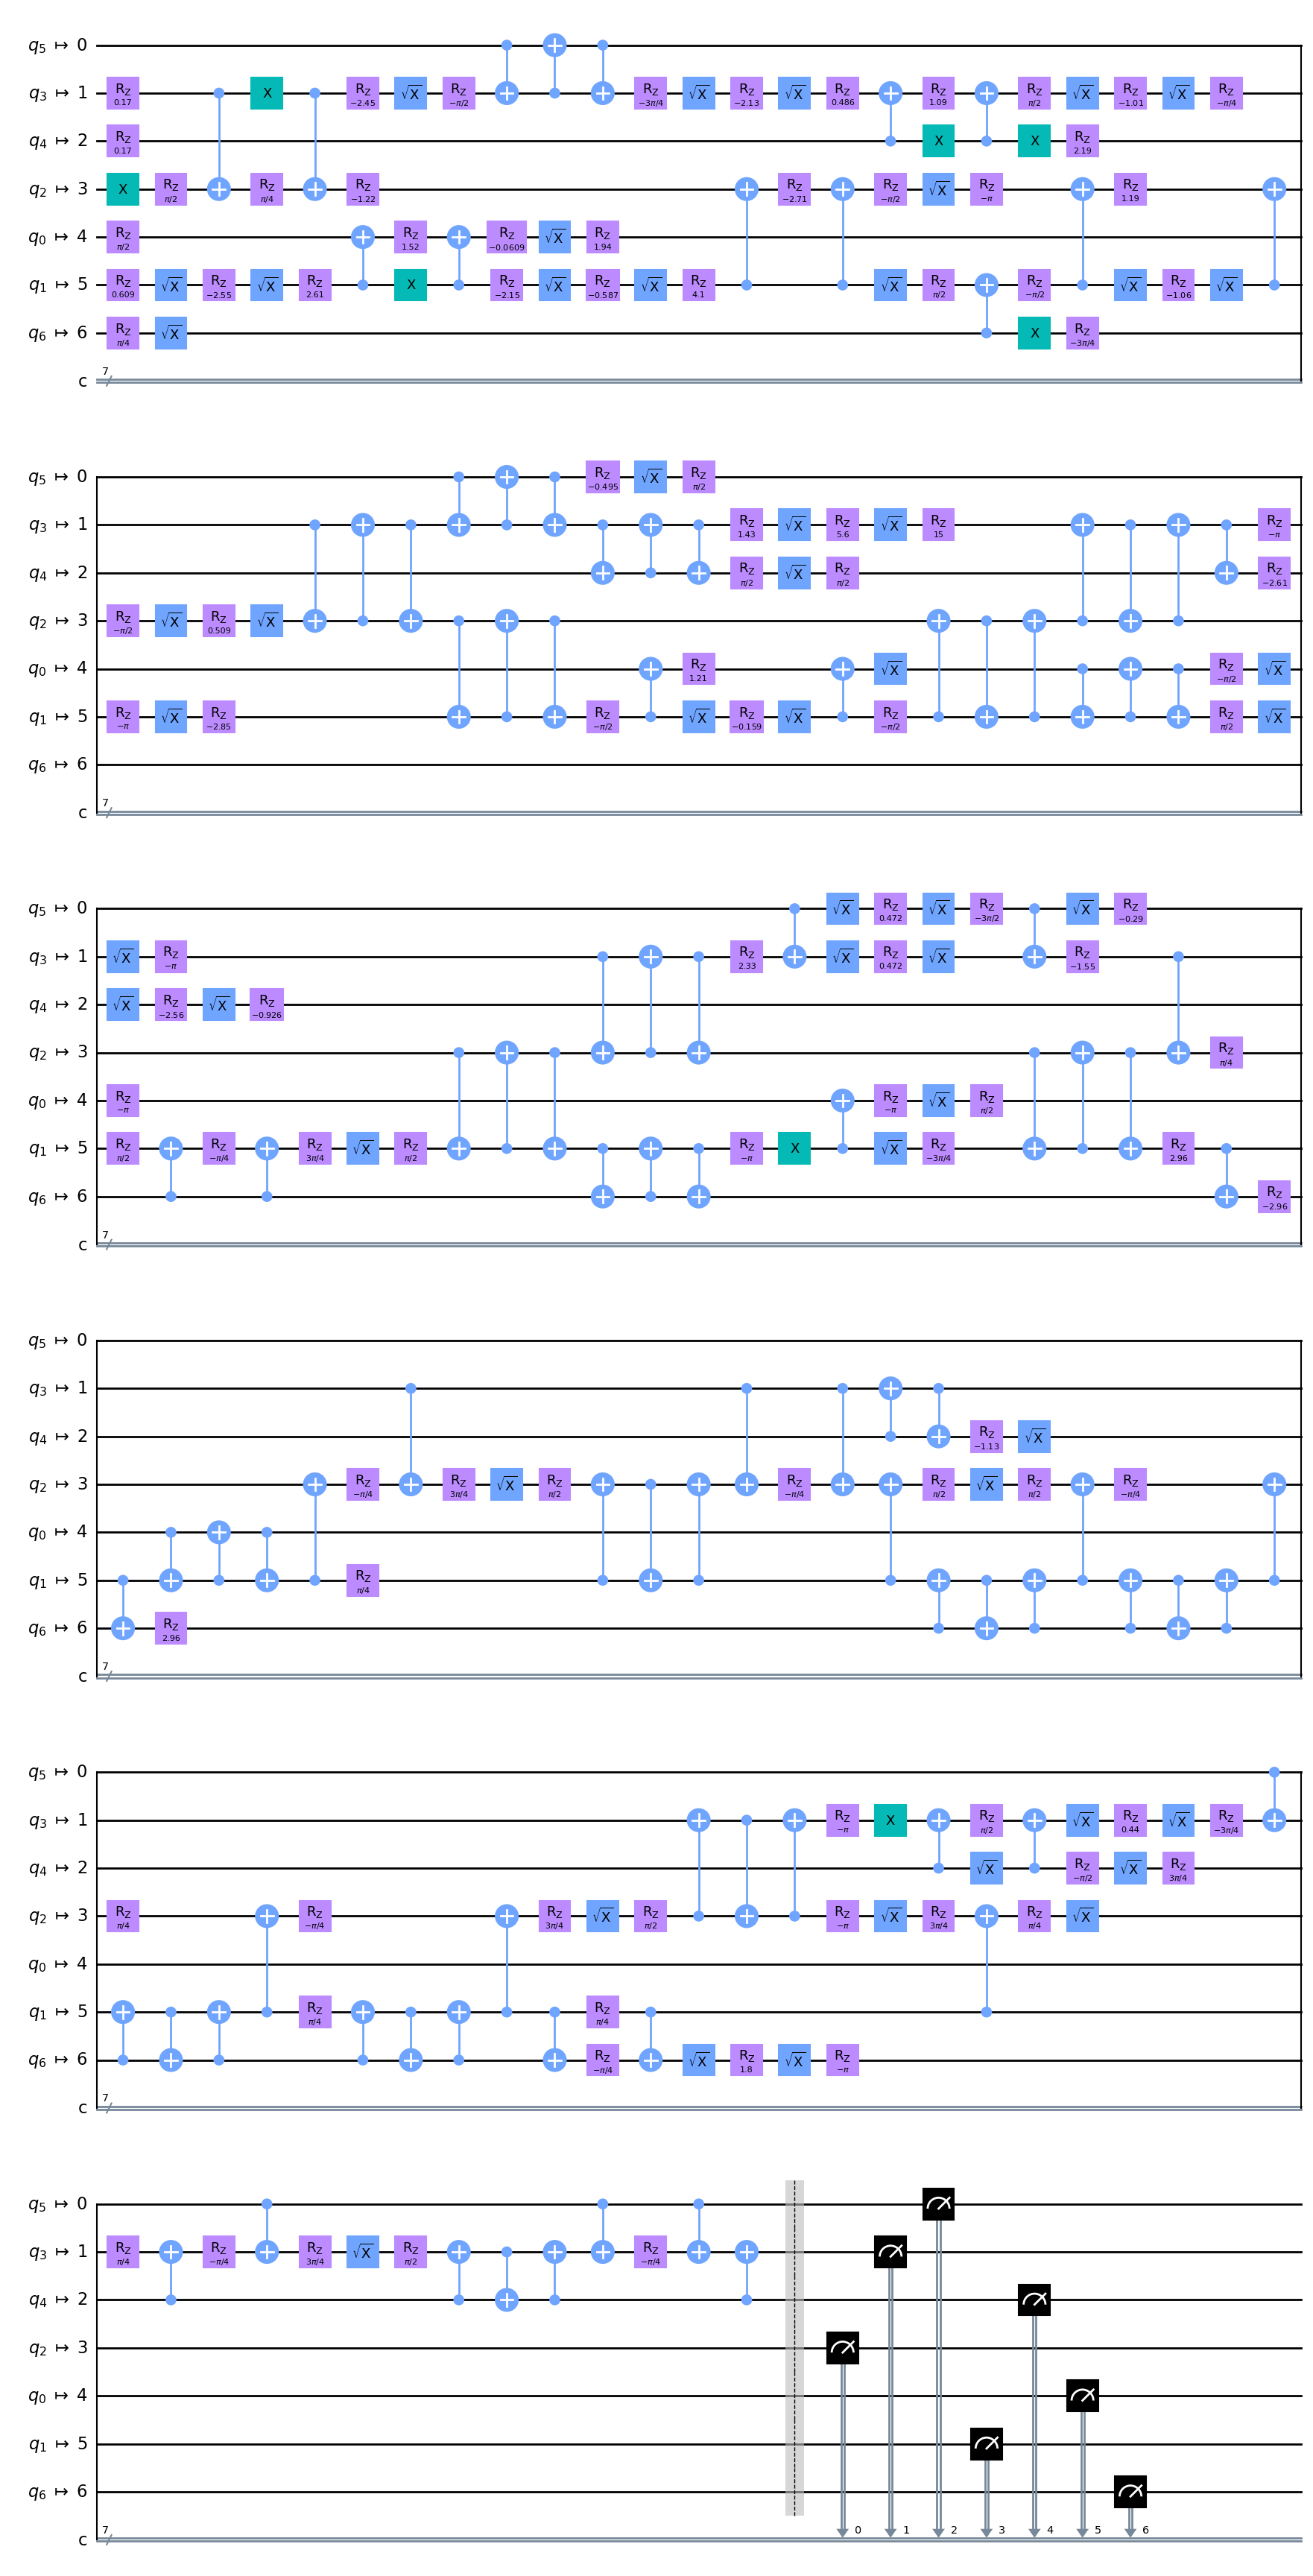

In [5]:
transpiled_qc.draw(output='mpl',idle_wires=True)

In [ ]:
# import TKET backend
from pytket.extensions.qiskit import IBMQBackend
tket_backend = IBMQBackend('ibmq_jakarta')

# import Qiskt <=> TKET circuit rewrite
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit

# convert already transpiled Qiskit circuit to TKET circuit
tket_qc = qiskit_to_tk(transpiled_qc)

from pytket.circuit.display import render_circuit_jupyter
render_circuit_jupyter(tket_qc)


In [ ]:
# use TKET default compilation (transpilation) pass
compiled_tket_qc = tket_backend.get_compiled_circuit(tket_qc,optimisation_level=2)

# convert TKET circuit to Qiskit circuit
compiled_qc = tk_to_qiskit(compiled_tket_qc)

compiled_qc.count_ops()


Qiskit `transpile` (optimization level 3)

| Gate    | Count |
|---------|-------|
| cx      | 104   |
| rz      | 106   |
| sx      | 51    |
| x       | 10    |


combined with TKET `get.compiled` (optimization level 2, default)

| Gate    | Count |
|---------|-------|
| cx      | 93    |
| rz      | 90    |
| sx      | 49    |
| x       | 13    |


In [ ]:
compiled_qc = tk_to_qiskit(compiled_tket_qc)

# By incorporating the TKET compiler into your workflow, you can potentially decrease the number of two-qubit gates in your circuit. This reduction can help mitigate errors during circuit execution.

Now compile to Quantinuum Devices

In [ ]:
from pytket.extensions.quantinuum import QuantinuumBackend
from pytket.circuit import Circuit, OpType
machine = "H1-1E"
backend = QuantinuumBackend(device_name=machine, machine_debug=True)
import pytket.extensions.quantinuum.backends.quantinuum as qtm
qtm._GATE_SET.add(OpType.ZZPhase)

compiled_circuit = backend.get_compiled_circuit(tket_qc, optimisation_level=2)

In [ ]:
print("Total number of gates =", compiled_circuit.n_gates)
print("Number of two qubit gates =", compiled_circuit.n_2qb_gates())

Total number of gates = 104
Number of two qubit gates = 32


## OpenQASM

- Open quantum assembly language
- Can be used to write circuits
- Servers as a platform-independent method of storing circuits
- TKET has bidirectional conversion support for QASM

In [ ]:
from pytket.qasm import circuit_from_qasm_str
from pytket.circuit.display import render_circuit_jupyter

openqasm = """
// Header
OPENQASM 2.0;
include "qelib1.inc";

// Registers
qreg q[2];
creg cr[2];

// Gates
h q[0];
CX q[0], q[1];

// Measurement
measure q -> cr;

"""

In [ ]:
circ = circuit_from_qasm_str(openqasm)
render_circuit_jupyter(circ)
